# Банковские рекомендации

**Модель для создание рекомендаций банковских продуктов клиентам**

В данном проекте мы проведем исследование имеющихся банковских данных и создадим систему рекомендаций банковских продуктов различным группам клиентов.

Основной целью будет приобретение клиентом большего количества банковских продуктов(кредиты, депозиты, инвестиционные продукты).

Для определения результатов работы моделей будем использовать задачу и метрики классификации.

Работа включает в себя полный цикл создания модели: от анализа данных до построения и оптимизации модели с последующим логированием и отслеживанием экспериментов.

Проект включает следующие ключевые этапы:

1. Предварительный анализ данных (EDA):

 - Исследование банковских транзакционных данных за разные месяцы;

 - Анализ структуры данных, пропущенных значений, распределения признаков;

 - Визуализация клиентской активности по времени.

2. Подготовка данных:

 - Отбор и предобработка данных за конкретные временные периоды;

 - Обработка категориальных признаков и устранение пропусков;

 - Формирование пользовательско-продуктовых матриц.

3. Построение рекомендательной модели:

 - Подготовка топ популярных банковских продуктов;

 - Использование алгоритма матричной факторизации AlternatingLeastSquares из библиотеки implicit для подготовки персональных рекомендаций.

 - Использование классификатора CatBoost для решения задачи ранжирования рекомендаций.

4. Оптимизация модели:

 - Подбор гиперпараметров с помощью библиотеки Optuna и интеграции с MLflow для логирования и сравнения экспериментов.

Для логирования и отслеживания экспериментов будем использовать MLflow 


## Загрузка данных и библиотек

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from implicit.als import AlternatingLeastSquares
import pathlib
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
import mlflow
from mlflow import MlflowClient
import optuna
from optuna.samplers import TPESampler
from optuna.integration.mlflow import MLflowCallback
from dotenv import load_dotenv

load_dotenv()

SEED = 777
DATA_RAW = pathlib.Path("../data/raw/train_ver2.csv")
DATA_FINAL_DIR = pathlib.Path("../data/processed")
ARTIF_EDA = pathlib.Path("../artifacts/EDA")
EXPERIMENT_NAME = "final_project"

pd.set_option("display.max_columns", None)

In [26]:
mlflow.create_experiment(EXPERIMENT_NAME)

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

## EDA

#### Обзор

Загрузим данные и посмотрим на них.

In [3]:
df = pd.read_csv(DATA_RAW)

/tmp/ipykernel_3392/3183141574.py:1: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_RAW)


In [4]:
df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

Количество уникальных пользователей во всех данных:

In [6]:
df.ncodpers.nunique()

956645

Посмотрим как будут выглядеть записи по одному рандомному пользователю

In [7]:
df.query("ncodpers == 1050611")

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1243389,2015-02-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1847833,2015-03-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2507211,2015-04-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2519199,2015-05-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3176928,2015-06-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4371719,2015-07-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
5136553,2015-08-28,1050611,N,ES,V,23,2012-08-10,0.0,36,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
6053847,2015-09-28,1050611,N,ES,V,23,2012-08-10,0.0,37,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
6492086,2015-10-28,1050611,N,ES,V,23,2012-08-10,0.0,38,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Количество уникальных данных у разных признаков:

In [8]:
df.nunique()

fecha_dato                   17
ncodpers                 956645
ind_empleado                  5
pais_residencia             118
sexo                          2
age                         235
fecha_alta                 6756
ind_nuevo                     2
antiguedad                  507
indrel                        2
ult_fec_cli_1t              223
indrel_1mes                  13
tiprel_1mes                   5
indresi                       2
indext                        2
conyuemp                      2
canal_entrada               162
indfall                       2
tipodom                       1
cod_prov                     52
nomprov                      52
ind_actividad_cliente         2
renta                    520994
segmento                      3
ind_ahor_fin_ult1             2
ind_aval_fin_ult1             2
ind_cco_fin_ult1              2
ind_cder_fin_ult1             2
ind_cno_fin_ult1              2
ind_ctju_fin_ult1             2
ind_ctma_fin_ult1             2
ind_ctop

Количество пропусков в данных

In [16]:
df.isna().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

В связи с большим количеством пропусков, взглянем на них еще раз после отделения части данных, необходимых для работы.

#### График количества клиентов в месяц

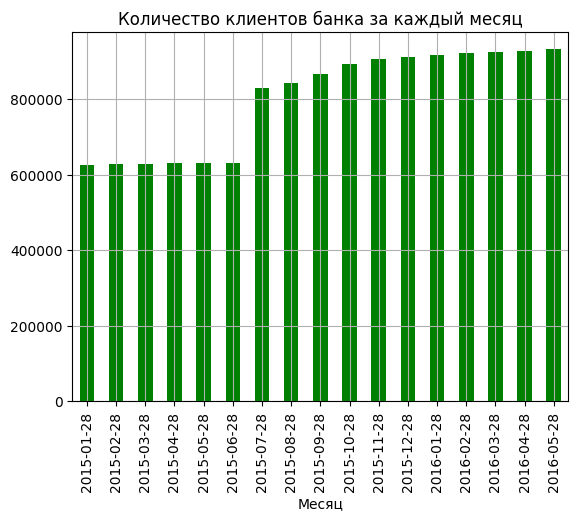

In [9]:
df.groupby("fecha_dato").agg({"ncodpers": "count"}).plot(
    kind="bar",
    title="Количество клиентов банка за каждый месяц",
    xlabel="Месяц",
    grid=True,
    colormap="ocean",
    legend=False,
)

plt.savefig(os.path.join(ARTIF_EDA, "fig_clients_by_month"))
plt.show()

#### Отделения части данных для дальнейшего анализа

Для анализа свойств пользователей и отсутствия повторов возьмем данные за один месяц и осмотрим их.

In [10]:
data_month = df.query("fecha_dato == '2016-03-28'").copy()

#### Форматы столбца `indrel_1mes`

In [11]:
data_month["indrel_1mes"].unique()

array([1.0, '1', '1.0', '3', '2', 'P', nan, '2.0', '3.0', '4.0', 2.0, 3.0,
       '4', 4.0], dtype=object)

Приведем данные к единому виду для построения графика по данному признаку

In [12]:
data_month["indrel_1mes"] = data_month.where(data_month.indrel_1mes != "P", int(5))[
    "indrel_1mes"
]
data_month.indrel_1mes = data_month.indrel_1mes.astype(float)

#### Распределения признаков, отвечающих за характеристику клиентов банка

In [13]:
fea = [
    "ind_empleado",
    "pais_residencia",
    "sexo",
    "age",
    "ind_nuevo",
    "antiguedad",
    "indrel",
    "ult_fec_cli_1t",
    "indrel_1mes",
    "tiprel_1mes",
    "indresi",
    "indext",
    "conyuemp",
    "canal_entrada",
    "indfall",
    "tipodom",
    "cod_prov",
    "ind_actividad_cliente",
    "renta",
    "segmento",
]

items = [
    "ind_ahor_fin_ult1",
    "ind_aval_fin_ult1",
    "ind_cco_fin_ult1",
    "ind_cder_fin_ult1",
    "ind_cno_fin_ult1",
    "ind_ctju_fin_ult1",
    "ind_ctma_fin_ult1",
    "ind_ctop_fin_ult1",
    "ind_ctpp_fin_ult1",
    "ind_deco_fin_ult1",
    "ind_deme_fin_ult1",
    "ind_dela_fin_ult1",
    "ind_ecue_fin_ult1",
    "ind_fond_fin_ult1",
    "ind_hip_fin_ult1",
    "ind_plan_fin_ult1",
    "ind_pres_fin_ult1",
    "ind_reca_fin_ult1",
    "ind_tjcr_fin_ult1",
    "ind_valo_fin_ult1",
    "ind_viv_fin_ult1",
    "ind_nomina_ult1",
    "ind_nom_pens_ult1",
    "ind_recibo_ult1",
]

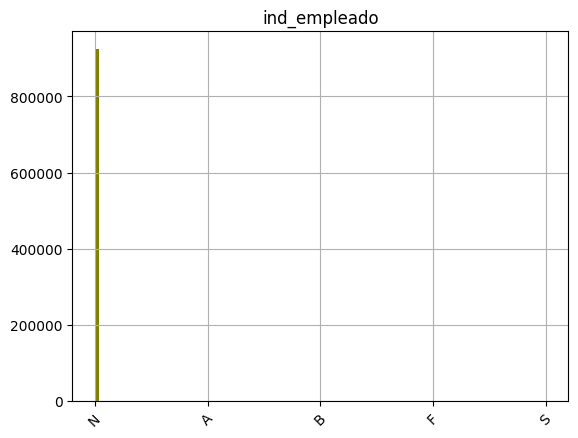

Unique values of ind_empleado_column - 5
Sum of Nan values of ind_empleado_column - 0


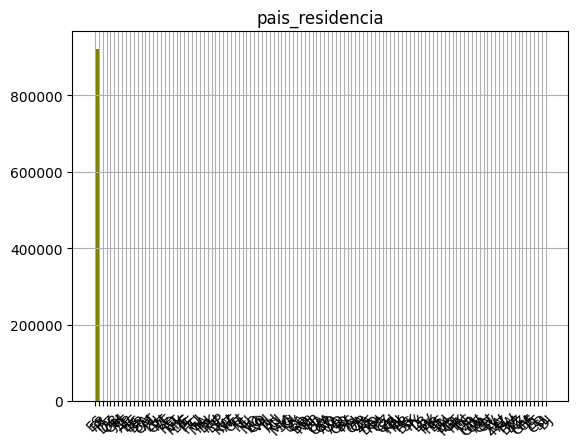

Unique values of pais_residencia_column - 117
Sum of Nan values of pais_residencia_column - 0


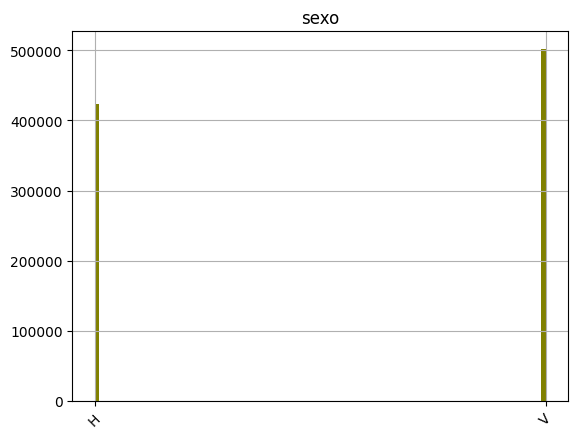

Unique values of sexo_column - 2
Sum of Nan values of sexo_column - 5


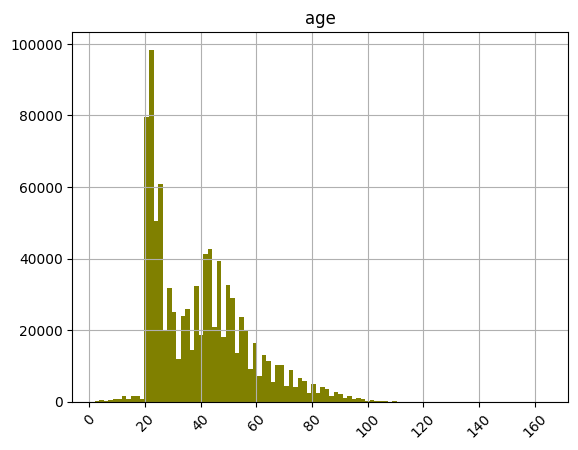

Unique values of age_column - 118
Sum of Nan values of age_column - 0


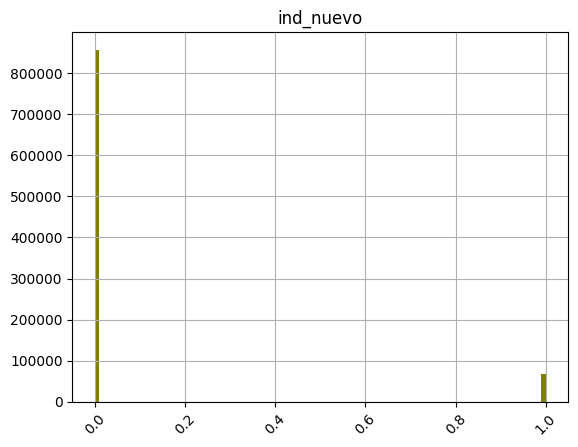

Unique values of ind_nuevo_column - 2
Sum of Nan values of ind_nuevo_column - 0


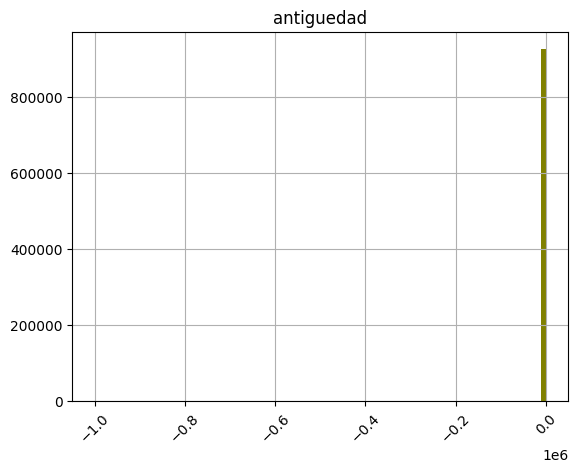

Unique values of antiguedad_column - 256
Sum of Nan values of antiguedad_column - 0


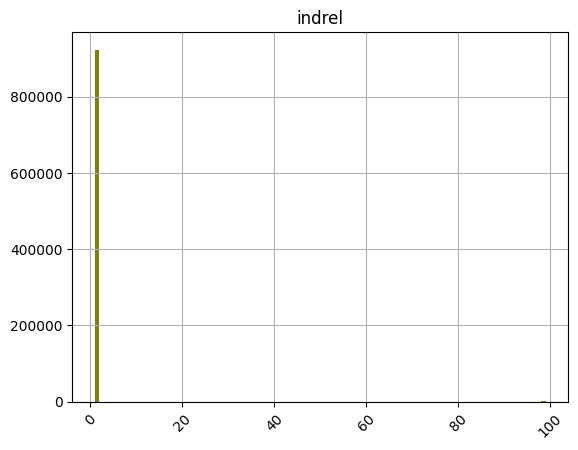

Unique values of indrel_column - 2
Sum of Nan values of indrel_column - 0


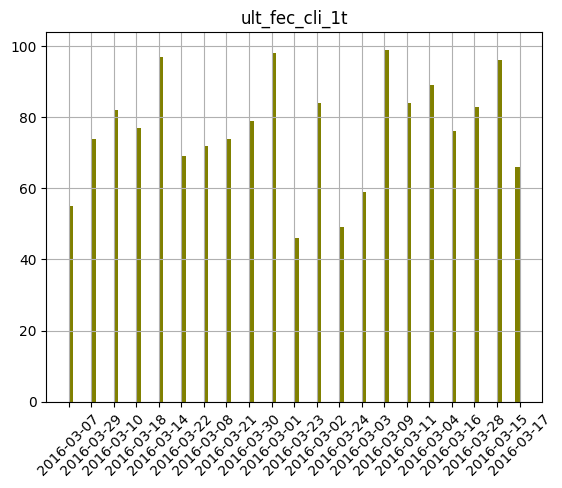

Unique values of ult_fec_cli_1t_column - 21
Sum of Nan values of ult_fec_cli_1t_column - 923468


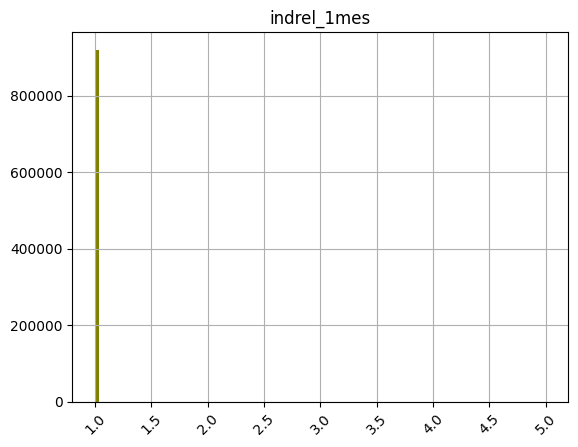

Unique values of indrel_1mes_column - 5
Sum of Nan values of indrel_1mes_column - 4655


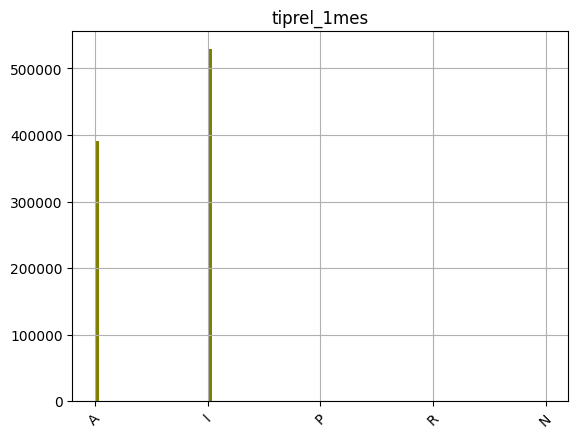

Unique values of tiprel_1mes_column - 5
Sum of Nan values of tiprel_1mes_column - 4655


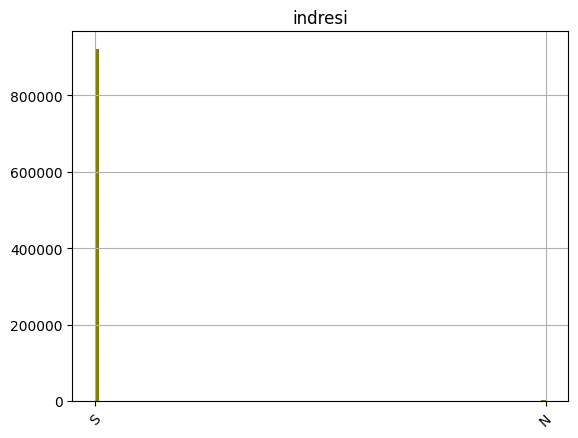

Unique values of indresi_column - 2
Sum of Nan values of indresi_column - 0


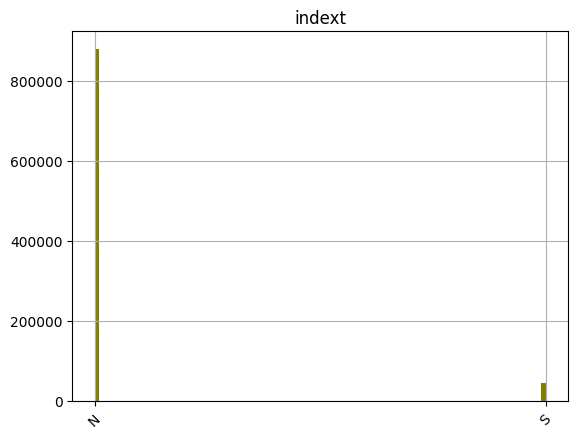

Unique values of indext_column - 2
Sum of Nan values of indext_column - 0


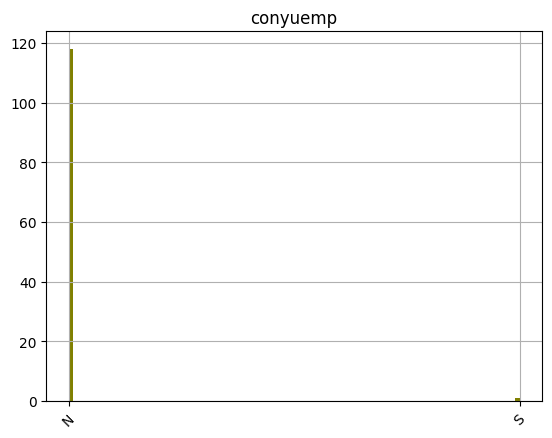

Unique values of conyuemp_column - 2
Sum of Nan values of conyuemp_column - 924957


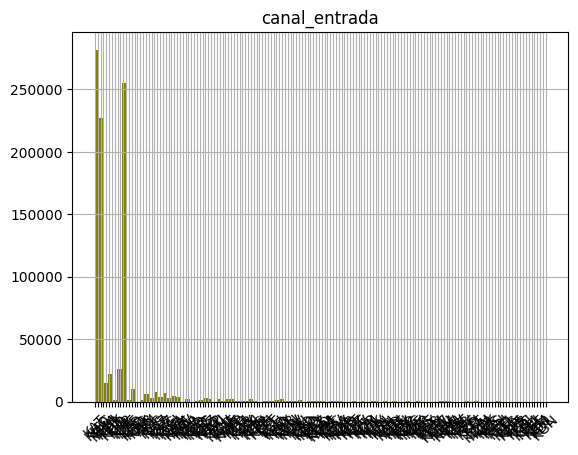

Unique values of canal_entrada_column - 160
Sum of Nan values of canal_entrada_column - 7555


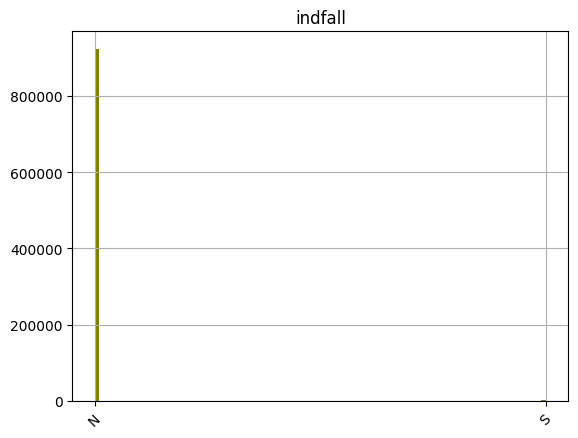

Unique values of indfall_column - 2
Sum of Nan values of indfall_column - 0


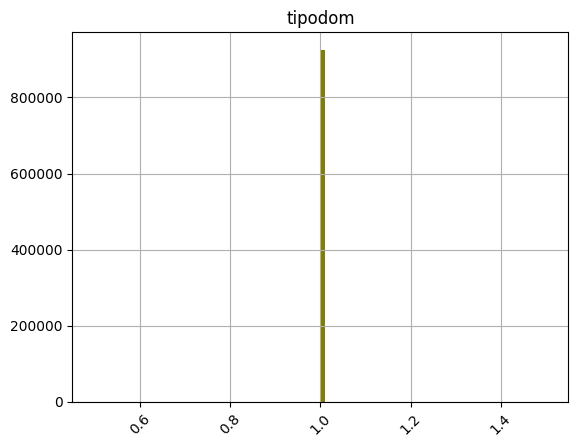

Unique values of tipodom_column - 1
Sum of Nan values of tipodom_column - 0


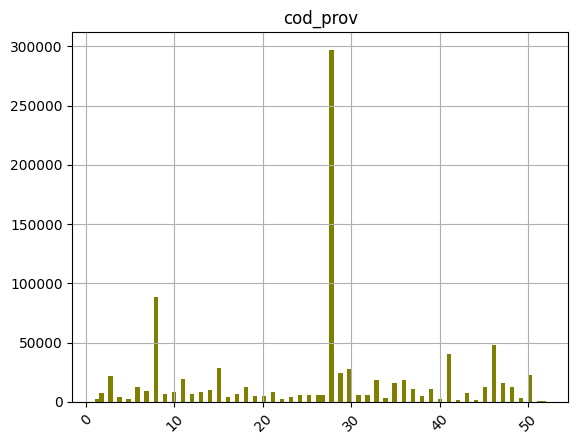

Unique values of cod_prov_column - 52
Sum of Nan values of cod_prov_column - 3988


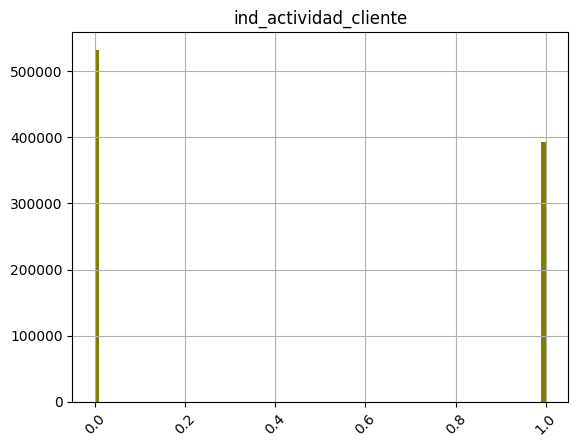

Unique values of ind_actividad_cliente_column - 2
Sum of Nan values of ind_actividad_cliente_column - 0


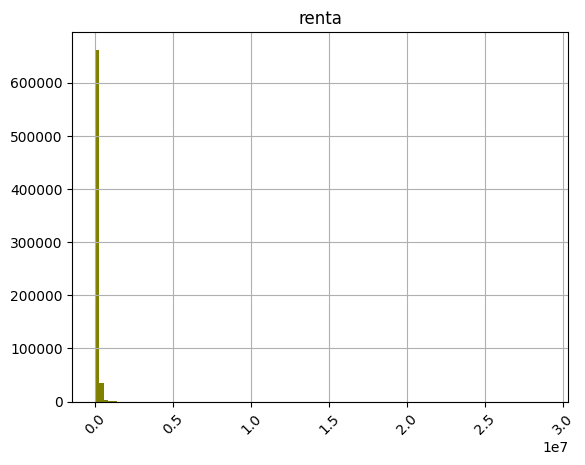

Unique values of renta_column - 517597
Sum of Nan values of renta_column - 221364


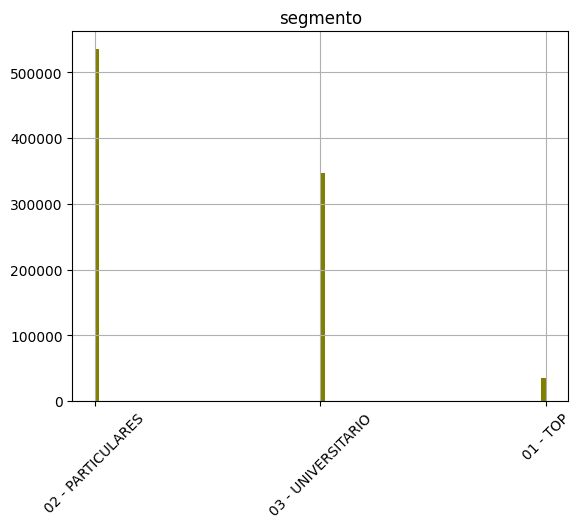

Unique values of segmento_column - 3
Sum of Nan values of segmento_column - 7840


In [14]:
for col in fea:
    data_month[col].hist(bins=100, xrot=45, color="olive")
    plt.title(col)
    plt.savefig(os.path.join(ARTIF_EDA, f"fig_hist_{col}"))
    plt.show()
    print(f"Unique values of {col}_column - {data_month[col].nunique()}")
    print(f"Sum of Nan values of {col}_column - {data_month[col].isna().sum()}")

#### Отдельно признак `ind_empleado`

In [15]:
data_month.ind_empleado.value_counts()

ind_empleado
N    924556
B       219
F       152
A       148
S         1
Name: count, dtype: int64

Судя по цифрам, почти все клиенты банка - безработные - это вызывает сомнения в правильности данного признака.

#### Популярные банковские продукты с учетом пола клиента

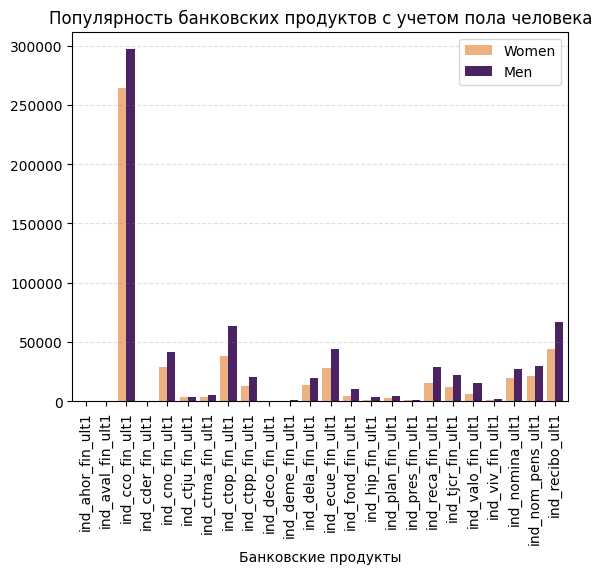

In [ ]:
pop_gender_items = data_month[items + ["sexo"]].groupby("sexo").sum()
ax = pop_gender_items.T.plot.bar(
    title="Популярность банковских продуктов с учетом пола человека",
    xlabel="Банковские продукты",
    colormap="flare",
    width=0.8,
)
ax.yaxis.grid(True, linestyle="--", which="major", color="grey", alpha=0.25)
ax.legend(["Women", "Men"])

plt.savefig(os.path.join(ARTIF_EDA, "fig_pop_product_by_sexo"))
plt.show()

Основной банковский продукт у пользователей любого пола - это просто некий "текущий счет" пользуется высокой популярность с большим отрывом от остальных. Следующие популярные продукты это - "Особый счёт", "Дебетовый аккаунт" и "Цифровой счёт".

#### Среднее количество банковских продуктов у пользователей

Добавим к данным суммарное количество банковских продуктов, имеющиеся у каждого пользователя.

In [17]:
data_month["sum_items"] = data_month[items].sum(axis=1)

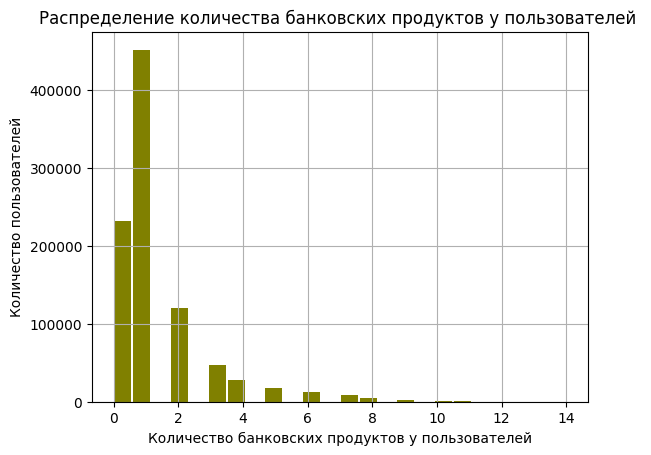

In [18]:
data_month["sum_items"].hist(bins=len(items), color="olive", rwidth=0.9)
plt.xlabel("Количество банковских продуктов у пользователей")
plt.ylabel("Количество пользователей")
plt.title("Распределение количества банковских продуктов у пользователей ")

plt.savefig(os.path.join(ARTIF_EDA, "fig_num_prods_by_user"))
plt.show()

В среднем клиенты имеют от 1 до 3 продуктов, реже больше. Также часть пользователей вообще не начала пользоваться услугами банка.

In [19]:
users_zero_prods = data_month.query("sum_items == 0").shape[0]
print(
    f" Количество пользователей не купившие в банке ни одного продукта = {users_zero_prods}"
)

 Количество пользователей не купившие в банке ни одного продукта = 231806


#### Выводы

В нашем распоряжении находится большая таблицы выгрузки из банковских данных за один год. В таблице около 13,5 млн строк и 48 столбцов.<br>
Данные разделены по датам и представляют из себя ежемесячную выгрузку о том, какой пользователь какие банковские продукты имеет в наличии в каждый месяц. Также добавлены данные о каждом пользователе. <br>
В таблице используется испанский язык для обозначения признаков и некоторых данных. <br>
По графику количества пользователей в каждый месяц видно, что в целом банк пользуется большой базой клиентов, постепенно наращивая ее.<br>
В целом, данные не очень чистые - имеется большое количество пропусков, выбросов и некорректных форматов данных.
По самим банковским продуктам можно сказать следующее:
- их не так уж много - 24 всевозможных вида;
- большинство пользователей использует 1-2 продукта. При этом около 20% пользователей вообще не начали использовать банк, а имеют только регистрацию. Клиенты с количеством продуктов больше 2 в меньшинстве. На увеличение доли таких клиентов и будет направлена система рекомендаций;
- при этом часть продуктов имеет особую специфику - для инвестиций, пенсионеров.

Для последующей работы с данными выделим несколько основных шагов:
1. Данные, которые мы не будем использовать в дальнейших расчетах и причины:
- столбец `nomprov` - по сути, дублирует столбец `cod_prov`, лишь расшифровывая его для понимания;
- столбец `fecha_alta` дата, первого договора клиента в банке дублируется столбцом со стажем клиента в месяцах `antiguedad`;
- столбец `ind_empleado` очень сильно разбалансирован, а его содержимое вызывает вопросы - как будто почти все клиенты банка являются безработными;
- столбец `indrel` сильно разбалансирован, и информацию о том, насколько первичный клиент, мы видим столбце со стажем;
- столбец `indresi` - большой дисбаланс, также информация о стране клиента останется в столбце `pais_residencia`;
- столбец `conyuemp` - дисбаланс, большое количество пропусков и наличие столбца `canal_entrada` - канал, по которому пришел пользователь;
- столбец `tipodom` - имеет всего одно значение на всех пользователей.

2. Столбцы с пропусками на которые обратим внимание в дальнейшем:
* Пропуски в столбце `ult_fec_cli_1t` - Последняя дата, когда клиент был премиальным, скорее всего говорят о том, что человек не находился в статусе премиального клиента или до сих пор находится в нем;
* В категориальных столбцах  `indrel_1mes` и `tiprel_1mes`;
* Пропуски в `canal_entrada`;
* Пропуски в кодировке провинции `cod_prov`;
* Пропуски в `renta` скорее всего означают отсутствие дохода домохозяйства;
* Пропуски в `segmento`, это либо пропущенные данные, либо пользователь который не подошел под стандартные категории.

3. Выбросы - в столбцах `antiguedad`, `inders_1mes` и `age` обратим внимание на подозрительный разброс данных и  значения-выбросы.


In [20]:
concls = """
В нашем распоряжении находится большая таблицы выгрузки из банковских данных за один год. В таблице около 13,5 млн строк и 48 столбцов.<br>
Данные разделены по датам и представляют из себя ежемесячную выгрузку о том, какой пользователь какие банковские продукты имеет в наличии в каждый месяц. Также добавлены данные о каждом пользователе. <br>
В таблице используется испанский язык для обозначения признаков и некоторых данных. <br>
По графику количества пользователей в каждый месяц видно, что в целом банк пользуется большой базой клиентов, постепенно наращивая ее.<br>
В целом, данные не очень чистые - имеется большое количество пропусков, выбросов и некорректных форматов данных.
По самим банковским продуктам можно сказать следующее:
- их не так уж много - 24 всевозможных вида;
- большинство пользователей использует 1-2 продукта. При этом около 20% пользователей вообще не начали использовать банк, а имеют только регистрацию. Клиенты с количеством продуктов больше 2 в меньшинстве. На увеличение доли таких клиентов и будет направлена система рекомендаций;
- при этом часть продуктов имеет особую специфику - для инвестиций, пенсионеров.

Для последующей работы с данными выделим несколько основных шагов:
1. Данные, которые мы не будем использовать в дальнейших расчетах и причины:
- столбец `nomprov` - по сути, дублирует столбец `cod_prov`, лишь расшифровывая его для понимания;
- столбец `fecha_alta` дата, первого договора клиента в банке дублируется столбцом со стажем клиента в месяцах `antiguedad`;
- столбец `ind_empleado` очень сильно разбалансирован, а его содержимое вызывает вопросы - как будто почти все клиенты банка являются безработными;
- столбец `indrel` сильно разбалансирован, и информацию о том, насколько первичный клиент, мы видим столбце со стажем;
- столбец `indresi` - большой дисбаланс, также информация о стране клиента останется в столбце `pais_residencia`;
- столбец `conyuemp` - дисбаланс, большое количество пропусков и наличие столбца `canal_entrada` - канал, по которому пришел пользователь;
- столбец `tipodom` - имеет всего одно значение на всех пользователей.

2. Столбцы с пропусками на которые обратим внимание в дальнейшем:
* Пропуски в столбце `ult_fec_cli_1t` - Последняя дата, когда клиент был премиальным, скорее всего говорят о том, что человек не находился в статусе премиального клиента или до сих пор находится в нем;
* В категориальных столбцах  `indrel_1mes` и `tiprel_1mes`;
* Пропуски в `canal_entrada`;
* Пропуски в кодировке провинции `cod_prov`;
* Пропуски в `renta` скорее всего означают отсутствие дохода домохозяйства;
* Пропуски в `segmento`, это либо пропущенные данные, либо пользователь который не подошел под стандартные категории.

3. Выбросы - в столбцах `antiguedad`, `inders_1mes` и `age` обратим внимание на подозрительный разброс данных и  значения-выбросы.
"""

In [21]:
with open(os.path.join(ARTIF_EDA, "conclusions.md"), "w", encoding="utf-8") as ff:
    ff.write(concls)

#### Mlflow

In [28]:
RUN_NAME = "EDA"

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id, RUN_NAME)

    mlflow.log_artifact(ARTIF_EDA, "EDA")

c8970fd5bec14ab7880134dff0918270 EDA


2024/10/26 17:27:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run EDA at: http://127.0.0.1:5000/#/experiments/14/runs/c8970fd5bec14ab7880134dff0918270.
2024/10/26 17:27:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/14.


## Преобразование и разделение данных

Почистим и преобразуем данные для последующей работы с ними

#### Разделение данных

Для начала оставим от  имеющихся данных только сведения о пользователях за последние 3 месяца. Для обучения модели рекомендаций, обучения ранжирующей модели и тестовых данных.

In [29]:
data_3_month = df.loc[
    df.fecha_dato.isin(["2016-03-28", "2016-04-28", "2016-05-28"])
].copy()
data_3_month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2784803 entries, 10862506 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta          

#### Лишние признаки

Сперва уберем ненужные и малоинформативные признаки чтобы не использовать их далее:
- столбец `nomprov`;
- столбец `fecha_alta`;
- столбец `ind_empleado`;
- столбец `indrel`;
- столбец `indresi`;
- столбец `conyuemp`;
- столбец `tipodom`.

In [30]:
features = [
    "fecha_dato",
    "ncodpers",
    "pais_residencia",
    "sexo",
    "age",
    "ind_nuevo",
    "antiguedad",
    "ult_fec_cli_1t",
    "indrel_1mes",
    "tiprel_1mes",
    "indext",
    "canal_entrada",
    "indfall",
    "cod_prov",
    "ind_actividad_cliente",
    "renta",
    "segmento",
]
items = [
    "ind_ahor_fin_ult1",
    "ind_aval_fin_ult1",
    "ind_cco_fin_ult1",
    "ind_cder_fin_ult1",
    "ind_cno_fin_ult1",
    "ind_ctju_fin_ult1",
    "ind_ctma_fin_ult1",
    "ind_ctop_fin_ult1",
    "ind_ctpp_fin_ult1",
    "ind_deco_fin_ult1",
    "ind_deme_fin_ult1",
    "ind_dela_fin_ult1",
    "ind_ecue_fin_ult1",
    "ind_fond_fin_ult1",
    "ind_hip_fin_ult1",
    "ind_plan_fin_ult1",
    "ind_pres_fin_ult1",
    "ind_reca_fin_ult1",
    "ind_tjcr_fin_ult1",
    "ind_valo_fin_ult1",
    "ind_viv_fin_ult1",
    "ind_nomina_ult1",
    "ind_nom_pens_ult1",
    "ind_recibo_ult1",
]

data_3_month = data_3_month[features + items]

#### Работа с пропусками

In [31]:
data_3_month.isna().sum()

fecha_dato                     0
ncodpers                       0
pais_residencia                0
sexo                          15
age                            0
ind_nuevo                      0
antiguedad                     0
ult_fec_cli_1t           2779737
indrel_1mes                12756
tiprel_1mes                12756
indext                         0
canal_entrada              21014
indfall                        0
cod_prov                   11970
ind_actividad_cliente          0
renta                     675637
segmento                   21915
ind_ahor_fin_ult1              0
ind_aval_fin_ult1              0
ind_cco_fin_ult1               0
ind_cder_fin_ult1              0
ind_cno_fin_ult1               0
ind_ctju_fin_ult1              0
ind_ctma_fin_ult1              0
ind_ctop_fin_ult1              0
ind_ctpp_fin_ult1              0
ind_deco_fin_ult1              0
ind_deme_fin_ult1              0
ind_dela_fin_ult1              0
ind_ecue_fin_ult1              0
ind_fond_f

* Пропуски в столбце `ult_fec_cli_1t` - Последняя дата, когда клиент был премиальным, скорее всего говорят о том, что человек не находился в статусе премиального клиента или до сих пор находится в нем. Заменим пропуски в этом столбце на 0.
* В категориальных столбцах  `indrel_1mes` и `tiprel_1mes` для пропусков добавим дополнительную категорию "0".
* Пропуски в `canal_entrada` также запишем в отдельную категорию "0".
* Пропуски в кодировке провинции `cod_prov` заменим на 0.                   
* Пропуски в `renta` скорее всего означают отсутствие дохода домохозяйства и тоже будут заменены на 0.
* Пропуски в `segmento`, это либо пропущенные данные, либо пользователь который не подошел под стандартные категории. Добавим для пропущенных значений отдельную категорию "4"

Напишем и используем функцию для заполнения пропусков в данных

In [ ]:
def fill_nan(data):
    for col in ["indrel_1mes", "tiprel_1mes", "canal_entrada"]:
        data[col] = data[col].fillna("0")
    for col in ["ult_fec_cli_1t", "renta", "cod_prov"]:
        data[col] = data[col].fillna(0)
    data["segmento"] = data["segmento"].fillna("4")
    return data


data_3_month = fill_nan(data_3_month)
data_3_month.isna().sum()

#### Работа с выбросами

Выброс в столбце `antiguedad`

В данном признаке присутствует значение -999999, таких записей очень мало, поэтому избавимся от них.

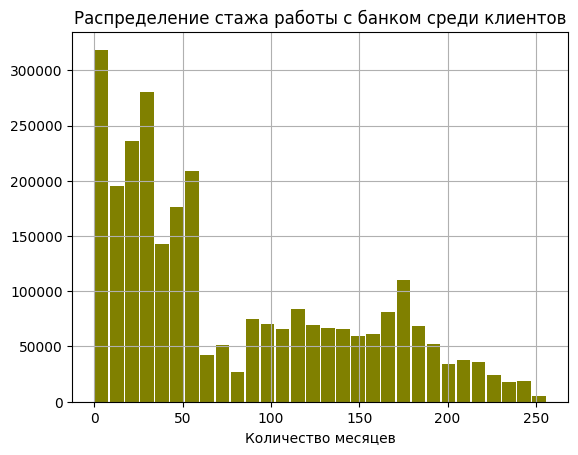

In [33]:
data_3_month = data_3_month[data_3_month["antiguedad"] != -999999]

data_3_month.antiguedad.hist(bins=30, color="olive", rwidth=0.9)
plt.title("Распределение стажа работы с банком среди клиентов")
plt.xlabel("Количество месяцев")
plt.show()

Колонка `age` - возраст пользователей.

В связи с большим разбросом возраста пользователей, оставим только пользователей с возрастом от совершеннолетия (18) до ста лет.

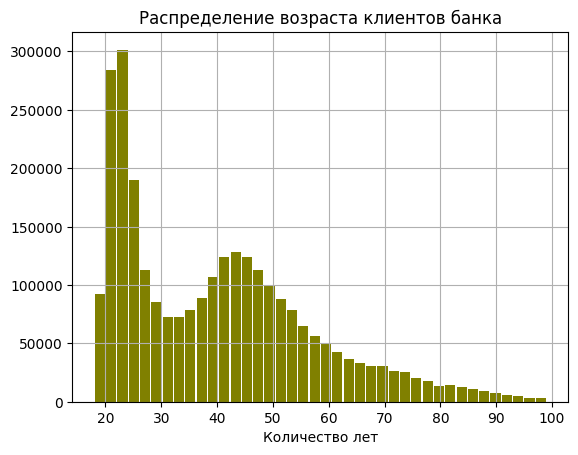

In [34]:
data_3_month = data_3_month[(data_3_month["age"] >= 18) & (data_3_month["age"] < 100)]

data_3_month.age.hist(bins=40, color="olive", rwidth=0.9)
plt.title("Распределение возраста клиентов банка")
plt.xlabel("Количество лет")
plt.show()

#### Работа с форматами

##### Столбец `inders_1mes` имеет некоторое количество разнородных данных

In [35]:
data_3_month["indrel_1mes"].unique()

array([1.0, '1', '1.0', '3', '2', 'P', '0', '2.0', '3.0', '4.0', 2.0, 3.0,
       '4', 4.0], dtype=object)

Заменим категорию "P" на категорию "5" и переведем все в формат `float`

In [36]:
data_3_month["indrel_1mes"] = data_3_month.where(
    data_3_month.indrel_1mes != "P", int(5)
)["indrel_1mes"]
data_3_month.indrel_1mes = data_3_month.indrel_1mes.astype(float)

##### Работа с признаком `ult_fec_cli_1t`

Данный признак имеет большое количество пропусков, а данные в нем показывают дату, когда клиент был премиальным. То есть там, где есть дата - клиент уже не премиальный. Приведем данный признак к бинарному виду:

 0 - если у клиента нет даты в данном признаке
 
 1 - если у клиента есть дата

In [37]:
data_3_month["ult_fec_cli_1t"] = data_3_month.where(
    data_3_month.ult_fec_cli_1t == 0, int(1)
)["ult_fec_cli_1t"].astype("Int16")

In [38]:
data_3_month["ult_fec_cli_1t"].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int16

##### Далее приведем данные к нужным нам форматам

In [39]:
col_to_int = [
    "age",
    "ind_nuevo",
    "antiguedad",
    "ult_fec_cli_1t",
    "indrel_1mes",
    "cod_prov",
    "ind_actividad_cliente",
]

col_to_category = [
    "pais_residencia",
    "sexo",
    "tiprel_1mes",
    "indext",
    "canal_entrada",
    "indfall",
    "segmento",
]

data_3_month["renta"] = data_3_month["renta"].astype(int)

data_3_month[items] = data_3_month[items].astype("int8")
data_3_month[col_to_int] = data_3_month[col_to_int].astype("int16")
data_3_month[col_to_category] = data_3_month[col_to_category].astype("category")

Итог:

In [40]:
data_3_month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2758995 entries, 10862506 to 13647308
Data columns (total 41 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   fecha_dato             object  
 1   ncodpers               int64   
 2   pais_residencia        category
 3   sexo                   category
 4   age                    int16   
 5   ind_nuevo              int16   
 6   antiguedad             int16   
 7   ult_fec_cli_1t         int16   
 8   indrel_1mes            int16   
 9   tiprel_1mes            category
 10  indext                 category
 11  canal_entrada          category
 12  indfall                category
 13  cod_prov               int16   
 14  ind_actividad_cliente  int16   
 15  renta                  int64   
 16  segmento               category
 17  ind_ahor_fin_ult1      int8    
 18  ind_aval_fin_ult1      int8    
 19  ind_cco_fin_ult1       int8    
 20  ind_cder_fin_ult1      int8    
 21  ind_cno_fin_ult1       int8 

### Разделение данных на train, validation and test

Для разработки моделей рекомендаций будем использовать данные за последние 3 месяца.

Для разработки модели персональных рекомендаций за `2016-03-28` даты.

Для обучения ранжирующей модели данные за `2016-04-28` даты.

Для тестирования и измерения метрик данные за `2016-05-28` даты.

In [41]:
data_train = data_3_month[data_3_month.fecha_dato == "2016-03-28"].copy()
data_val = data_3_month[data_3_month.fecha_dato == "2016-04-28"].copy()
data_test = data_3_month[data_3_month.fecha_dato == "2016-05-28"].copy()
for data in [data_train, data_val, data_test]:
    print(data.shape)

(916485, 41)
(919669, 41)
(922841, 41)


In [42]:
data_train.to_parquet("../data/processed/data_train.parquet")
data_val.to_parquet("../data/processed/data_val.parquet")
data_test.to_parquet("../data/processed/data_test.parquet")

## Разработка моделей рекомендаций

Для разработки рекомендаций попробуем несколько способов:
1. Для "холодных" пользователей, тех у кого нет ни одного банковского продукта в наличии - подготовим топ популярных банковских продуктов.
2. Для пользователей, имеющих опыт работы с банком подготовим персональные рекомендации на основе модели Alternating Least Squares (ALS).
3. Улучшим ALS рекомендации за счет добавления признаков пользователей и обучения ранжирующей модели.

Для оценки рекомендаций будем смотреть на то, появились ли новые банковские продукты у пользователя в месяце, следующем за рекомендациями. И на то, насколько новые продукты соответствуют тем рекомендациям, которые были даны пользователю.

В качестве метрик - будем использовать метрики классификации - Precision@k, Recall@k и F1-score@k.

#### Подготовим функции для разметки данных персональных рекомендаций и для вычисления метрик.  

In [78]:
def markers_for_metrics_topk(
    recs: pd.DataFrame,
    data_train: pd.DataFrame,
    data_test: pd.DataFrame,
    items: list,
    users: str,
    score: str,
    top_k: int,
) -> pd.DataFrame:
    """
    Размечаем результаты рекомендаций по тестовым данным:
    preds - предсказание;
    gt - ground true
    tp - true positive
    fp - false positive
    fn - false negative
    """
    # В первую очередь оставим в тестовых данных только общих пользователей
    common_users = set(data_test[users]) & set(data_train[users])
    filtered_data_test = data_test[data_test[users].isin(common_users)].copy()

    # Уберем те продукты, которыми пользователь итак
    # пользовался во временной период data_train

    filtered_data_test = filtered_data_test[[users] + items].melt(
        id_vars=users, var_name="item_id", value_name="gt"
    )

    melted_data_train = data_train[[users] + items].melt(
        id_vars=users, var_name="item_id", value_name="mark"
    )

    filtered_data_test = filtered_data_test.merge(
        melted_data_train[[users, "item_id", "mark"]], how="left", on=[users, "item_id"]
    )
    filtered_data_test = filtered_data_test.query("mark == 0")

    # добавим к рекомендациям столбец с бинарной меткой "preds"
    recs["preds"] = True

    # Добавим к данным top_k рекомендаций
    recs = recs.sort_values(by=[users, score], ascending=[True, False])
    recs_top_k = recs.groupby(users).head(top_k)

    data_test_marks = filtered_data_test.merge(
        recs_top_k[[users, "item_id", "preds"]], how="left", on=[users, "item_id"]
    )
    data_test_marks["preds"] = data_test_marks["preds"].fillna(False)

    # Оставим в тестовых данных информацию только о top_k рекомендаций
    # и top_k продуктов, которые не были рекомендованы.

    data_test_marks = data_test_marks.sort_values(
        by=[users, "preds", "gt"], ascending=[True, False, False]
    )
    data_test_marks = data_test_marks.groupby(by=[users, "preds"]).head(3)

    data_test_marks["tp"] = data_test_marks["gt"] & data_test_marks["preds"]
    data_test_marks["fp"] = ~data_test_marks["gt"] & data_test_marks["preds"]
    data_test_marks["fn"] = data_test_marks["gt"] & ~data_test_marks["preds"]

    return data_test_marks

In [87]:
def compute_metrics_topk(data_with_marks: pd.DataFrame, users: str, top_k: int):
    """
    Рассчитываем precision@top_k, recall@top_k и f1@top_k.
    """
    metrics = {}
    groupper = data_with_marks.groupby(users)

    # precision@topk
    precision = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fp"].sum())
    metrics[f"precision_top{top_k}"] = precision.fillna(0).mean()

    # recall@topk
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    metrics[f"recall_top{top_k}"] = recall.fillna(0).mean()

    # f1@topk
    f1 = (2 * groupper["tp"].sum()) / (
        2 * groupper["tp"].sum() + groupper["fp"].sum() + groupper["fn"].sum()
    )
    metrics[f"f1_top{top_k}"] = f1.fillna(0).mean()

    return metrics

### Рекомендации для новых пользователей, или пользователей без банковских продуктов

In [43]:
pop_items = data_train[items].sum()

pop_items = (
    pop_items.sort_values(ascending=False)
    .reset_index()
    .rename(columns={0: "num_users", "index": "item_id"})
)
pop_items.head()

,item_id,num_users
0,ind_cco_fin_ult1,561036
1,ind_recibo_ult1,110903
2,ind_ctop_fin_ult1,100979
3,ind_ecue_fin_ult1,72048
4,ind_cno_fin_ult1,70135


In [44]:
pop_items.to_parquet("../service_app/recs/pop_items.parquet")

### Подготовка данных users and items


Для модели ALS подготовим кодирование пользователей и продуктов, и spars-матрицу user-item

Для персональных рекомендаций на основании истории взаимодействия, необходимо оставить только пользователей, у которых были хоть какие-то взаимодействия с банковскими продуктами.

In [46]:
data_train["sum_items"] = data_train[items].sum(axis=1)
hot_users_train = data_train.query("sum_items > 0").copy()
hot_users_train.shape

(686181, 42)

In [47]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(hot_users_train["ncodpers"])

item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items)

LabelEncoder()

Создание матрицы user-item

In [ ]:
data_matrix = hot_users_train[["ncodpers"] + items]
data_matrix.ncodpers = user_encoder.transform(data_matrix["ncodpers"])
data_matrix = data_matrix.set_index("ncodpers").sort_index()
data_matrix.head()

In [49]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    data_matrix,
    dtype=np.int8,
)

### Подготовка модели персональных рекомендаций ALS

#### Создадим модель коллаборативной фильтрации ALS и сразу ее обучим.

In [80]:
model_als_params = {
    "factors": 100,
    "iterations": 100,
    "regularization": 0.05,
    "random_state": SEED,
}

als_model = AlternatingLeastSquares(**model_als_params)
als_model.fit(user_item_matrix_train)

Напишем функцию для получения рекомендаций для всех пользователей.

In [64]:
def get_recommendations_als(
    user_item_matrix, model, user_id, user_encoder, item_encoder, new_recs=True, n=5
):
    """
    Возвращает отранжированные рекомендации для заданных пользователей
    """
    user_id_enc = user_encoder.transform(user_id)
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=new_recs,
        N=n,
    )
    recommendations = pd.DataFrame(
        {
            "item_id": recommendations[0].flatten(),
            "score": recommendations[1].flatten(),
        },
        index=np.array([[user] * n for user in user_id]).flatten(),
    )
    recommendations["item_id"] = item_encoder.inverse_transform(
        recommendations["item_id"]
    )
    recommendations = recommendations.reset_index(names="ncodpers")

    return recommendations

Проверим работу модели

In [65]:
get_recommendations_als(
    user_item_matrix_train, als_model, [1052336, 15889], user_encoder, item_encoder
)

,ncodpers,item_id,score
0,1052336,ind_nomina_ult1,0.000792
1,1052336,ind_recibo_ult1,0.000292
2,1052336,ind_nom_pens_ult1,0.000201
3,1052336,ind_ctju_fin_ult1,0.000157
4,1052336,ind_tjcr_fin_ult1,0.000146
5,15889,ind_nom_pens_ult1,0.000674
6,15889,ind_plan_fin_ult1,0.000518
7,15889,ind_fond_fin_ult1,0.000465
8,15889,ind_ahor_fin_ult1,0.000388
9,15889,ind_ctop_fin_ult1,0.000237


Получим рекомендации для всех пользователей

In [66]:
user_ids = user_encoder.classes_

als_recommendations = get_recommendations_als(
    user_item_matrix_train, als_model, user_ids, user_encoder, item_encoder, n=10
)

In [67]:
als_recommendations

,ncodpers,item_id,score
0,15889,ind_nom_pens_ult1,0.000674
1,15889,ind_plan_fin_ult1,0.000518
2,15889,ind_fond_fin_ult1,0.000465
3,15889,ind_ahor_fin_ult1,0.000388
4,15889,ind_ctop_fin_ult1,0.000237
...,...,...,...
6861805,1542630,ind_tjcr_fin_ult1,0.000084
6861806,1542630,ind_ctju_fin_ult1,0.000080
6861807,1542630,ind_ctpp_fin_ult1,0.000076
6861808,1542630,ind_plan_fin_ult1,0.000068


In [ ]:
als_recommendations.to_parquet("../data/recs/als_clean.parquet")

#### Посчитаем основные метрики таких рекомендаций

In [89]:
als_markers = markers_for_metrics_topk(
    als_recommendations, data_train, data_val, items, "ncodpers", "score", 3
)

metrics_als = compute_metrics_topk(als_markers, "ncodpers", 3)
metrics_als

{'precision_top3': 0.0029843953707165242,
 'recall_top3': 0.0066025989982663146,
 'f1_top3': 0.0039324673545400365}

#### Mlflow

In [92]:
RUN_NAME = "als_recommendations"
REGISTRY_MODEL_NAME = "ALS_model"

pip_requirements = "../requirements.txt"
metadata = {"model_type": "ALS implicit"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_als)

    mlflow.log_params(model_als_params)

    model_info = mlflow.sklearn.log_model(
        sk_model=als_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "final_project")

49bbc5c0b4e74fa88204ae3ca711f08b


2024/10/26 19:44:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/26 19:44:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ALS_model'.
2024/10/26 19:44:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: ALS_model, version 1
Created version '1' of model 'ALS_model'.
2024/10/26 19:44:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run als_recommendations at: http://127.0.0.1:5000/#/experiments/14/runs/49bbc5c0b4e74fa88204ae3ca711f08b.
2024/10/26 19:44:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/14.


### Модель для ранжирования рекомендаций

#### Подготовка функций для работы модели

Для функции целевой переменной соберем из данных следующего месяца пары user-item с признаком наличия или отсутствия продукта

In [106]:
def get_target(
    recs: pd.DataFrame,
    data_test: pd.DataFrame,
    users: str,
    items: list,
) -> pd.DataFrame:
    """
    Из тестовых данных о использовании пользователем продуктов получаем
    столбец target, добавляем его к рекомендациям.
    Оставляем только тех пользователей, у кого есть хоть один положительный target
    """
    data_target = data_test[[users] + items].melt(
        id_vars=users, var_name="item_id", value_name="target"
    )

    recs = recs.merge(
        data_target[[users, "item_id", "target"]], how="left", on=[users, "item_id"]
    )

    positive_recs = recs.groupby(users).filter(lambda x: x["target"].sum() > 0)

    positive_recs.target.hist(color="olive", rwidth=0.9)
    plt.title("Распределение целевого признака")
    plt.show()

    return positive_recs

Функция для обучения ранжирующей модели

In [107]:
def train_model(
    data_with_target: pd.DataFrame,
    target_name: str,
    model_params: dict,
    model,
    cb: bool = True,
    categ_features_index: list = None,
):
    """
    Функция для обучения модели
    """
    features = data_with_target.drop(target_name, axis=1).columns
    model_fitted = model(**model_params)

    if cb:
        train_data = Pool(
            data=data_with_target[features],
            label=data_with_target[target_name],
            cat_features=categ_features_index,
        )
        model_fitted.fit(train_data)
    else:
        model_fitted.fit(data_with_target[features], data_with_target[target_name])

    return model_fitted

Функция для ранжирования рекомендаций

In [108]:
def ranging_recs(
    fitted_model,
    data_for_ranging: pd.DataFrame,
    user_ids: str,
    trans_columns: list,
    data_transformer: ColumnTransformer = False,
) -> pd.DataFrame:
    """
    Ранжирование рекомендаций уже обученной моделью fitted_model
    """

    if data_transformer:
        encoded_data = data_transformer.transform(data_for_ranging)

        encoded_data = pd.DataFrame(
            encoded_data, columns=data_transformer.get_feature_names_out()
        )

        data_for_ranging = pd.concat(
            [data_for_ranging.reset_index(), encoded_data.reset_index()], axis=1
        ).drop(list(trans_columns) + ["index"], axis=1)

    predictions = fitted_model.predict_proba(data_for_ranging)
    data_for_ranging["rang_score"] = predictions[:, 1]

    data_for_ranging = data_for_ranging.sort_values(
        [user_ids, "rang_score"], ascending=[True, False]
    )

    return data_for_ranging

#### Работа с признаками

##### Добавление признаков из начального датасета

Для обучения ранжирующей модели оставим в данных только тех пользователей, которые есть в валидационных данных. И добавим все признаки, содержащие сведения о клиентах.

In [97]:
candidates = als_recommendations.copy()
candidates.shape

(6861810, 4)

In [98]:
candidates = candidates[candidates["ncodpers"].isin(data_val["ncodpers"])]

In [99]:
features = [
    "ncodpers",
    "pais_residencia",
    "sexo",
    "age",
    "ind_nuevo",
    "antiguedad",
    "ult_fec_cli_1t",
    "indrel_1mes",
    "tiprel_1mes",
    "indext",
    "canal_entrada",
    "indfall",
    "cod_prov",
    "ind_actividad_cliente",
    "renta",
    "segmento",
]

candidates = candidates.merge(data_train[features], how="left", on="ncodpers")
candidates.head()

,ncodpers,item_id,score,preds,pais_residencia,sexo,age,ind_nuevo,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento
0,15889,ind_nom_pens_ult1,0.000674,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP
1,15889,ind_plan_fin_ult1,0.000518,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP
2,15889,ind_fond_fin_ult1,0.000465,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP
3,15889,ind_ahor_fin_ult1,0.000388,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP
4,15889,ind_ctop_fin_ult1,0.000237,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP


##### Добавление дополнительных признаков

Добавим сведения о том, сколько клиент имеет банковских продуктов на данный момент.

In [ ]:
data_train["sum_items"] = data_train[items].sum(axis=1).astype("Int8")

candidates = candidates.merge(
    data_train[["ncodpers", "sum_items"]], how="left", on="ncodpers"
)
candidates.head()

Также добавим информацию о рекомендуемом продукте - количество пользователей, которые в данный момент его используют или, другими словами, популярность банковского продукта

In [101]:
candidates = candidates.merge(
    pop_items[["num_users", "item_id"]], how="left", on="item_id"
)
candidates["num_users"] = candidates["num_users"].astype("Int32")
candidates.head()

,ncodpers,item_id,score,preds,pais_residencia,sexo,age,ind_nuevo,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,sum_items,num_users
0,15889,ind_nom_pens_ult1,0.000674,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP,4,50903
1,15889,ind_plan_fin_ult1,0.000518,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP,4,7364
2,15889,ind_fond_fin_ult1,0.000465,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP,4,14878
3,15889,ind_ahor_fin_ult1,0.000388,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP,4,78
4,15889,ind_ctop_fin_ult1,0.000237,True,ES,V,56,0,253,0,1,A,N,KAT,N,28,1,326124,01 - TOP,4,100979


##### Подготовка целевой переменной

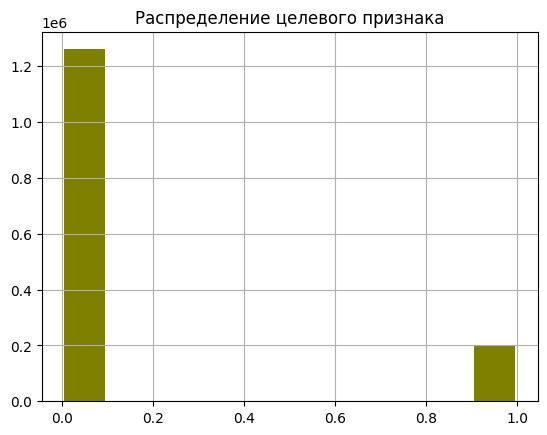

In [102]:
candidates = get_target(candidates, data_val, "ncodpers", items)

Мы имеем приемлемый дисбаланс целевой переменной

#### Подготовка объекта columns_transformer для обработки данных и генерации новых признаков

Для кодирования категориальных переменных используем OrdinalEncoder.

Также добавим несколько новых признаков из имеющихся числовых за счет применения логарифмической функции и экспоненты:
- к признаку `score` применим экспоненциальную функцию.
- к признакам `renta`, `num_users` и `antiguedad` применим логарифмическую функцию

In [103]:
cat_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1
)

num_exp_encoder = FunctionTransformer(
    np.exp,
    feature_names_out=lambda self, input_features: [f"exp_{c}" for c in input_features],
)

num_log_encoder = FunctionTransformer(
    np.log1p,
    feature_names_out=lambda self, input_features: [f"log_{c}" for c in input_features],
)


cat_columns = candidates.select_dtypes("category").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_encod", cat_encoder, cat_columns),
        ("exp_encod", num_exp_encoder, ["score"]),
        ("log_encod", num_log_encoder, ["renta", "num_users", "antiguedad"]),
    ],
    n_jobs=-1,
)

In [104]:
encoded_candidates = preprocessor.fit_transform(candidates)

encoded_candidates = pd.DataFrame(
    encoded_candidates, columns=preprocessor.get_feature_names_out()
)

candidates_new_data = pd.concat(
    [candidates.reset_index(), encoded_candidates.reset_index()], axis=1
).drop(list(cat_columns) + ["index"], axis=1)
candidates_new_data.head()

,ncodpers,item_id,score,preds,age,ind_nuevo,antiguedad,ult_fec_cli_1t,indrel_1mes,cod_prov,ind_actividad_cliente,renta,sum_items,num_users,target,cat_encod__pais_residencia,cat_encod__sexo,cat_encod__tiprel_1mes,cat_encod__indext,cat_encod__canal_entrada,cat_encod__indfall,cat_encod__segmento,exp_encod__exp_score,log_encod__log_renta,log_encod__log_num_users,log_encod__log_antiguedad
0,15890,ind_cco_fin_ult1,0.054199,True,63,0,254,0,1,28,1,71461,8,561036,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.055695,11.176921,13.237542,5.541264
1,15890,ind_hip_fin_ult1,0.000569,True,63,0,254,0,1,28,1,71461,8,4562,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000569,11.176921,8.425736,5.541264
2,15890,ind_aval_fin_ult1,0.000456,True,63,0,254,0,1,28,1,71461,8,16,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000456,11.176921,2.833213,5.541264
3,15890,ind_ahor_fin_ult1,0.000401,True,63,0,254,0,1,28,1,71461,8,78,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000401,11.176921,4.369448,5.541264
4,15890,ind_plan_fin_ult1,0.000239,True,63,0,254,0,1,28,1,71461,8,7364,1,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000239,11.176921,8.904494,5.541264


#### Обучение ранжирующей модели

In [109]:
model_base_params = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 5,
    "loss_function": "Logloss",
    "verbose": 100,
    "random_seed": SEED,
}

model = train_model(
    candidates_new_data,
    target_name="target",
    model_params=model_base_params,
    model=CatBoostClassifier,
    cb=True,
    categ_features_index=[1],
)

0:	learn: 0.5490338	total: 577ms	remaining: 9m 36s
100:	learn: 0.1204449	total: 45.3s	remaining: 6m 42s
200:	learn: 0.1019783	total: 1m 30s	remaining: 5m 58s
300:	learn: 0.0936205	total: 2m 15s	remaining: 5m 14s
400:	learn: 0.0882896	total: 3m 1s	remaining: 4m 30s
500:	learn: 0.0841071	total: 3m 47s	remaining: 3m 46s
600:	learn: 0.0809903	total: 4m 33s	remaining: 3m 1s
700:	learn: 0.0786838	total: 5m 19s	remaining: 2m 16s
800:	learn: 0.0766547	total: 6m 5s	remaining: 1m 30s
900:	learn: 0.0754598	total: 6m 51s	remaining: 45.3s
999:	learn: 0.0743298	total: 7m 38s	remaining: 0us


#### Оценка ранжирующей модели

Чтобы оценить насколько хорошо работает обученная модель необходимо подготовить рекомендации за валидационный период отранжировать их и оценить на тестовом месяце.

##### Подготовка данных

In [110]:
data_val["sum_items"] = data_val[items].sum(axis=1)
hot_users_val = data_val.query("sum_items > 0").copy()

In [112]:
user_encoder_val = sklearn.preprocessing.LabelEncoder()
user_encoder_val.fit(hot_users_val["ncodpers"])

LabelEncoder()

##### Создание матрицы user-item

In [113]:
data_matrix_val = hot_users_val[["ncodpers"] + items]
data_matrix_val.ncodpers = user_encoder_val.transform(data_matrix_val["ncodpers"])
data_matrix_val = data_matrix_val.set_index("ncodpers").sort_index()
data_matrix_val.head()

/tmp/ipykernel_3392/1577906762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix_val.ncodpers = user_encoder_val.transform(data_matrix_val["ncodpers"])


,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,1,1


In [114]:
user_item_matrix_val = scipy.sparse.csr_matrix(
    data_matrix_val,
    dtype=np.int8,
)

##### Подготовка модели персональных рекомендаций ALS

In [ ]:
model_als_params = {
    "factors": 100,
    "iterations": 100,
    "regularization": 0.05,
    "random_state": SEED,
}

als_model_val = AlternatingLeastSquares(**model_als_params)
als_model_val.fit(user_item_matrix_val)

In [116]:
user_ids_val = user_encoder_val.classes_

als_recommendations_val = get_recommendations_als(
    user_item_matrix_val,
    als_model_val,
    user_ids_val,
    user_encoder_val,
    item_encoder,
    n=10,
)
als_recommendations_val.head()

,ncodpers,item_id,score
0,15889,ind_valo_fin_ult1,0.000352
1,15889,ind_deco_fin_ult1,0.000331
2,15889,ind_tjcr_fin_ult1,0.000264
3,15889,ind_cno_fin_ult1,0.000226
4,15889,ind_ctma_fin_ult1,0.000213


##### Подготовка дополнительных признаков для валидационных данных

In [117]:
candidates_val = als_recommendations_val.copy()
candidates_val = candidates_val[candidates_val["ncodpers"].isin(data_test["ncodpers"])]

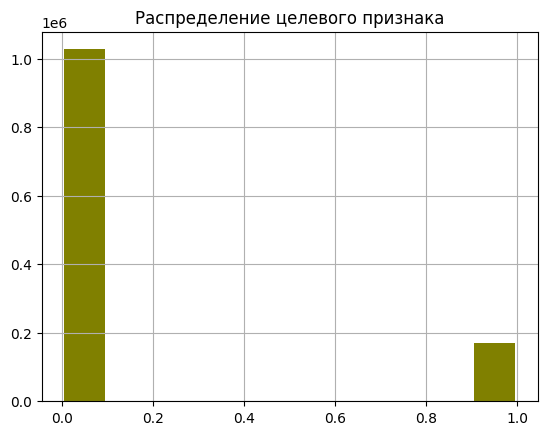

,ncodpers,item_id,score,pais_residencia,sexo,age,ind_nuevo,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indext,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,sum_items,num_users,target
0,15889,ind_valo_fin_ult1,0.000352,ES,V,56,0,254,0,1,A,N,KAT,N,28,1,326124,01 - TOP,3,21451,1
1,15889,ind_deco_fin_ult1,0.000331,ES,V,56,0,254,0,1,A,N,KAT,N,28,1,326124,01 - TOP,3,331,0
2,15889,ind_tjcr_fin_ult1,0.000264,ES,V,56,0,254,0,1,A,N,KAT,N,28,1,326124,01 - TOP,3,34325,1
3,15889,ind_cno_fin_ult1,0.000226,ES,V,56,0,254,0,1,A,N,KAT,N,28,1,326124,01 - TOP,3,70135,0
4,15889,ind_ctma_fin_ult1,0.000213,ES,V,56,0,254,0,1,A,N,KAT,N,28,1,326124,01 - TOP,3,8712,0


In [118]:
features = [
    "ncodpers",
    "pais_residencia",
    "sexo",
    "age",
    "ind_nuevo",
    "antiguedad",
    "ult_fec_cli_1t",
    "indrel_1mes",
    "tiprel_1mes",
    "indext",
    "canal_entrada",
    "indfall",
    "cod_prov",
    "ind_actividad_cliente",
    "renta",
    "segmento",
]

candidates_val = candidates_val.merge(data_val[features], how="left", on="ncodpers")

data_val["sum_items"] = data_val[items].sum(axis=1).astype("Int8")

candidates_val = candidates_val.merge(
    data_val[["ncodpers", "sum_items"]], how="left", on="ncodpers"
)
candidates_val = candidates_val.merge(
    pop_items[["num_users", "item_id"]], how="left", on="item_id"
)
candidates_val["num_users"] = candidates_val["num_users"].astype("Int32")

candidates_val = get_target(candidates_val, data_test, "ncodpers", items)
candidates_val.head()

##### Ранжирование рекомендаций обученной ранее моделью

In [119]:
recs_val = ranging_recs(
    model,
    candidates_val,
    "ncodpers",
    cat_columns,
    preprocessor,
)
recs_val

,ncodpers,item_id,score,age,ind_nuevo,antiguedad,ult_fec_cli_1t,indrel_1mes,cod_prov,ind_actividad_cliente,renta,sum_items,num_users,target,cat_encod__pais_residencia,cat_encod__sexo,cat_encod__tiprel_1mes,cat_encod__indext,cat_encod__canal_entrada,cat_encod__indfall,cat_encod__segmento,exp_encod__exp_score,log_encod__log_renta,log_encod__log_num_users,log_encod__log_antiguedad,rang_score
0,15889,ind_valo_fin_ult1,0.000352,56,0,254,0,1,28,1,326124,3,21451,1,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000353,12.695036,9.973573,5.541264,0.822692
9,15889,ind_plan_fin_ult1,0.000111,56,0,254,0,1,28,1,326124,3,7364,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000111,12.695036,8.904494,5.541264,0.106876
2,15889,ind_tjcr_fin_ult1,0.000264,56,0,254,0,1,28,1,326124,3,34325,1,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000264,12.695036,10.443658,5.541264,0.092313
5,15889,ind_nomina_ult1,0.000206,56,0,254,0,1,28,1,326124,3,47029,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000206,12.695036,10.758541,5.541264,0.013390
8,15889,ind_viv_fin_ult1,0.000115,56,0,254,0,1,28,1,326124,3,2982,0,21.0,1.0,1.0,0.0,24.0,0.0,0.0,1.000115,12.695036,8.000685,5.541264,0.008309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198106,1548049,ind_valo_fin_ult1,0.000078,29,1,0,0,0,21,1,0,1,21451,0,21.0,0.0,0.0,0.0,0.0,0.0,3.0,1.000078,0.0,9.973573,0.0,0.009523
1198102,1548049,ind_viv_fin_ult1,0.000119,29,1,0,0,0,21,1,0,1,2982,0,21.0,0.0,0.0,0.0,0.0,0.0,3.0,1.000119,0.0,8.000685,0.0,0.001473
1198104,1548049,ind_deco_fin_ult1,0.000087,29,1,0,0,0,21,1,0,1,331,0,21.0,0.0,0.0,0.0,0.0,0.0,3.0,1.000087,0.0,5.805135,0.0,0.000209
1198108,1548049,ind_ctma_fin_ult1,0.000069,29,1,0,0,0,21,1,0,1,8712,1,21.0,0.0,0.0,0.0,0.0,0.0,3.0,1.000069,0.0,9.072571,0.0,0.000055


##### Сделаем разметку и посчитаем метрики

In [ ]:
als_rang_markers = markers_for_metrics_topk(
    recs_val, data_val, data_test, items, "ncodpers", "rang_score", 3
)

metrics_als_rang = compute_metrics_topk(als_rang_markers, "ncodpers", 3)
metrics_als_rang

In [126]:
compare = pd.DataFrame(
    [metrics_als, metrics_als_rang], index=["als_clean", "rang_model"]
)
compare.style.highlight_max(color="olive", axis=0).format("{:.4}")

,precision_top3,recall_top3,f1_top3
als_clean,0.002984,0.006603,0.003932
rang_model,0.004002,0.007096,0.00482


Отлично! Ранжирующая модель заметно улучшила метрики. Лучше всего увеличилась Precision@3 наших предсказаний

#### Mlflow

In [ ]:
RUN_NAME = "ranging_model"
REGISTRY_MODEL_NAME = "ranging_model"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(
    candidates_val[:10], recs_val[:10], model.get_params()
)
input_example = candidates_val[:10]
metadata = {"model_type": "CatBoost"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_als_rang)
    mlflow.log_params(model.get_params())

    preproc_info = mlflow.sklearn.log_model(
        preprocessor, artifact_path="ckl_preprocessor"
    )

    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "final_project")

### Улучшение ранжирующей модели

#### Подбор гиперпараметров

Для улучшения модели используем подбор гиперпараметров методом Bayesian Optimization. 

Подбор будем осуществлять при помощи библиотеки `optuna`.


Для начал напишем `trial` который будет использовать `optuna`

In [131]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "depth": trial.suggest_int("depth", 2, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.3, 5),
        "random_strength": trial.suggest_float("random_strength", 0.1, 5),
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "loss_function": "Logloss",
        "task_type": "CPU",
        "random_seed": SEED,
        "early_stopping_rounds": 15,
        "verbose": False,
    }

    model = train_model(
        candidates_new_data,
        target_name="target",
        model_params=param,
        model=CatBoostClassifier,
        cb=True,
        categ_features_index=[1],
    )

    prediction = ranging_recs(
        model,
        candidates,
        "ncodpers",
        cat_columns,
        preprocessor,
    )

    prediction_markers = markers_for_metrics_topk(
        prediction, data_train, data_val, items, "ncodpers", "rang_score", 3
    )

    metrics = compute_metrics_topk(prediction_markers, "ncodpers", 3)
    return metrics["f1_top3"]

In [ ]:
RUN_NAME = "params_search"
STUDY_NAME = "final_project_2"
STUDY_DB_NAME = "sqlite:///local.study.db"

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="f1_top3",
    create_experiment=False,
    mlflow_kwargs={
        "experiment_id": experiment_id,
        "tags": {MLFLOW_PARENT_RUN_ID: run_id},
        "nested": True,
    },
)


SAMPLER = TPESampler(seed=SEED)
study_tpe = optuna.create_study(
    sampler=SAMPLER, direction="maximize", study_name=STUDY_NAME, storage=STUDY_DB_NAME
)


study_tpe.optimize(
    objective,
    n_trials=30,
    show_progress_bar=True,
    callbacks=[mlflc],
)

best_params_tpe = study_tpe.best_params
train_score_tpe = study_tpe.best_value

print(f"Best params for TPE {best_params_tpe}")

print(f"Best score for train TPE {train_score_tpe}")

Параметры подобраны, сохраним результаты и посмотрим на влияния отдельных гиперпараметров на оценки работы модели.

In [134]:
with open("../artifacts/models/best_params.json", "w") as fd:
    json.dump(best_params_tpe, fd)

In [7]:
STUDY_NAME = "final_project_2"
STUDY_DB_NAME = "sqlite:///local.study.db"

study_tpe = optuna.create_study(
    study_name=STUDY_NAME, storage=STUDY_DB_NAME, load_if_exists=True
)

[I 2024-10-27 08:24:50,344] Using an existing study with name 'final_project_2' instead of creating a new one.


In [8]:
print("\033[1m" + "Parameter importance TPE:")
fig = optuna.visualization.plot_param_importances(study_tpe)

fig.show()

Parameter importance TPE:


In [10]:
print("\033[1m" + "Parameter relationships TPE:")
fig = optuna.visualization.plot_parallel_coordinate(
    study_tpe,
    params=["depth", "learning_rate", "l2_leaf_reg", "random_strength", "iterations"],
)
fig.show()

Parameter relationships TPE:


В целом, можно сказать, что достичь лучших оценок можно при различных сочетаниях гиперпараметров. Но малые значение глубины деревьев и низкие значения шага обучения точно не приведут к более качественным результатам.

#### Переобучение модели и оценка результатов

Переобучим модель для ранжирования с учетом подобранного оптимального набора гиперпараметров и посмотрим результаты работы модели  на тестовых данных.

In [ ]:
model_final = train_model(
    candidates_new_data,
    target_name="target",
    model_params=best_params_tpe,
    model=CatBoostClassifier,
    cb=True,
    categ_features_index=[1],
)

recs_val_final = ranging_recs(
    model_final,
    candidates_val,
    "ncodpers",
    cat_columns,
    preprocessor,
)


als_rang_markers_final = markers_for_metrics_topk(
    recs_val_final, data_val, data_test, items, "ncodpers", "rang_score", 3
)

metrics_rang_optuna = compute_metrics_topk(als_rang_markers_final, "ncodpers", 3)
metrics_rang_optuna

In [142]:
compare_plus = pd.DataFrame(metrics_rang_optuna, index=["after_optuna"])

compare = pd.concat([compare, compare_plus], axis=0)

compare.style.highlight_max(color="olive", axis=0).format("{:.4}")

,precision_top3,recall_top3,f1_top3
als_clean,0.002984,0.006603,0.003932
rang_model,0.004002,0.007096,0.00482
after_optuna,0.004549,0.007784,0.005408


Подбор гиперпараметров способствовал увеличению всех метрик, что явно пойдет на пользу сервису рекомендаций.

Сохраним отранжированные рекомендации для нашего сервиса.

In [143]:
recs_val_final.to_parquet("../service_app/recs/ranging_recs.parquet")

#### Mlflow

In [ ]:
RUN_NAME = "ranging_model_final"
REGISTRY_MODEL_NAME = "ranging_model_final"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(
    candidates_val[:10], recs_val_final[:10], model_final.get_params()
)
input_example = candidates_val[:10]
metadata = {"model_type": "CatBoost"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_rang_optuna)
    mlflow.log_params(model_final.get_params())

    model_info = mlflow.catboost.log_model(
        cb_model=model_final,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "final_project")

# Вывод

По результатам анализа имеющихся данных были выбраны и разработаны модели для выдачи рекомендаций как постоянным клиентам, так и "холодным" клиентам банка. 